# Chapter 12: Deadlocks

Definition: 
given a concurrent program with multiple threads or processes, the execution flow enters a deadlock if a process (or thread) is waiting on a resource that is being held and utilized by another process, which is, in turn, waiting for another resource that is held by a different process.

## Coffman conditions

1. At least one resource has to be in a non-shareable state. This means that that resource is being held by an individual process (or thread) and cannot be accessed by others; the resource can only be accessed and held by a single process (or thread) at any given time. This condition is also known as __mutual exclusion__.
2. One process (or thread) exists that is simultaneously accessing a resource and waiting for another held by other processes (or threads). In other words, this process (or thread) needs access to two resources to execute its instructions, one of which it is already holding, the other of which it is waiting for from other processes (or threads). This condition is called __hold and wait__.
3. Resources can only be released by a process (or a thread) holding them if there are specific instructions for the process (or thread) to do so. This is to say that unless the process (or thread) voluntarily and actively releases the resource, that resource remains in a non-shareable state. This is the __no preemption condition__.
4. The final condition is called __circular wait__. As its name suggests, this condition specifies that a set of processes (or threads) exist so that the first process (or thread) in the set is waiting for a resource to be released by the second process (or thread), which, in turn, needs to be waiting for the third process (or thread); finally, the last process (or thread) in the set is waiting for the first one.

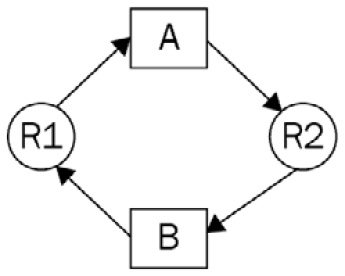


### Python simulation
In this section, we will implement the preceding situation in an actual Python program. Specifically, we will have two locks (we will call them __lock A__ and __lock B__) and two separate threads interacting with the locks (__thread A__ and __thread B__). In our program, we will set up a situation in which thread A has acquired lock A and is waiting to acquire lock B, which has already been acquired by thread B, which is, in turn, waiting for lock A to be released.

In [ ]:
import threading
import time


def thread_a():
    print("Thread A is starting...")

    print("Thread A waiting to acquire lock A.")
    lock_a.acquire()
    print("Thread A has acquired lock A, performing some calculation...")
    time.sleep(2)

    print("Thread A waiting to acquire lock B.")
    lock_b.acquire()
    print("Thread A has acquired lock B, performing some calculation...")
    time.sleep(2)

    print("Thread A releasing both locks.")
    lock_a.release()
    lock_b.release()


def thread_b():
    print("Thread B is starting...")

    print("Thread B waiting to acquire lock B.")
    lock_b.acquire()
    print("Thread B has acquired lock B, performing some calculation...")
    time.sleep(5)

    print("Thread B waiting to acquire lock A.")
    lock_a.acquire()
    print("Thread B has acquired lock A, performing some calculation...")
    time.sleep(5)

    print("Thread B releasing both locks.")
    lock_b.release()
    lock_a.release()


lock_a = threading.Lock()
lock_b = threading.Lock()

thread1 = threading.Thread(target=thread_a)
thread2 = threading.Thread(target=thread_b)

thread1.start()
thread2.start()

thread1.join()
thread2.join()

print("Finished.")


As we discussed previously, since each thread is trying to acquire a lock that is currently held by the other thread, the only way for a lock to be released is for a thread to continue its execution. This is a deadlock, and your program will hang infinitely, never reaching the final print statement in the last line of the program.

The following diagram further illustrates the process of how the deadlock unfolds, in sequence:

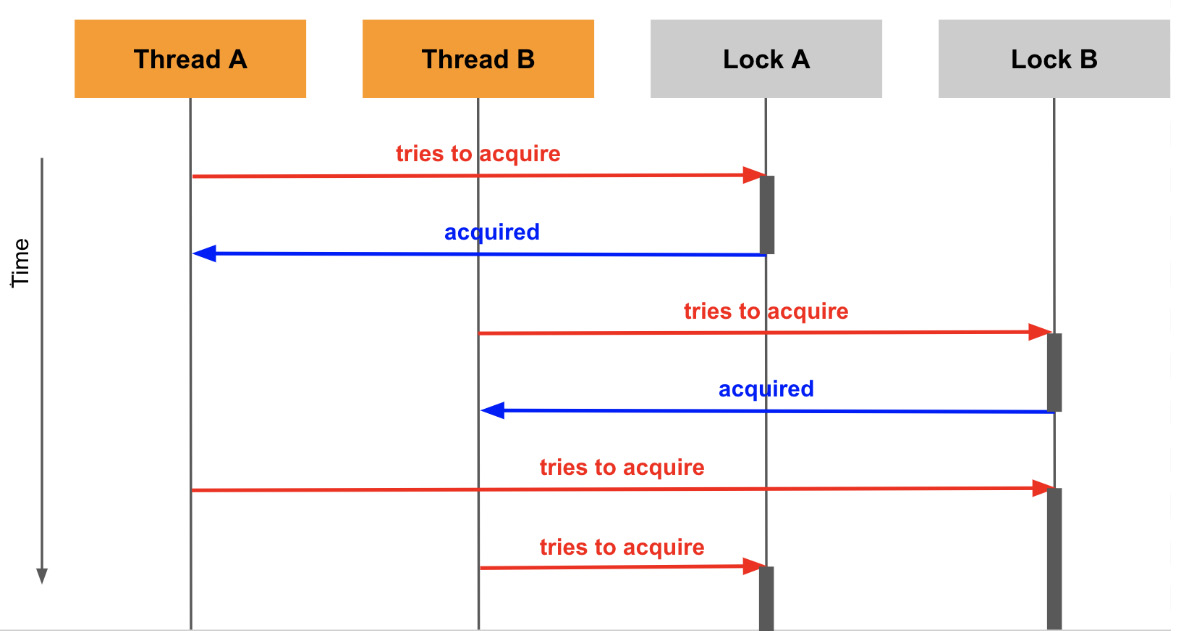

This behavior is undesirable in every way. In the next section, we will be discussing potential approaches to prevent deadlocks from occurring.



## Approaches to deadlock situations

### Implementing ranking among resources
We can see that the last condition of the four Coffman conditions, __circular wait__, is at the heart of the deadlock problem. It specifies that the different processes (or threads) in our concurrent program wait for resources held by other processes (or threads) circularly. By taking a closer look, we can see that the root cause for this condition is the __order (or lack thereof__) in which the processes (or threads) access the resources.

The conclusion that we can infer from this is that if, instead of accessing the resources arbitrarily, __the processes (or threads) were to access them in a predetermined, static order__, the circular nature of the way that they acquire and wait for the resources will be eliminated. So, for our two-lock Python example, instead of having thread A try to acquire lock A and thread B try to acquire lock B in their respective execution instructions, we will want both threads to try and acquire the locks in the same order. For example, __both threads will now try to acquire lock A first, perform some calculations, try to acquire lock B__, perform further calculations, and, finally, release both threads.


In [3]:
import threading
import time


def thread_a():
    print("Thread A is starting...")

    print("Thread A waiting to acquire lock A.")
    lock_a.acquire()
    print("Thread A has acquired lock A, performing some calculation...")
    time.sleep(2)

    print("Thread A waiting to acquire lock B.")
    lock_b.acquire()
    print("Thread A has acquired lock B, performing some calculation...")
    time.sleep(2)

    print("Thread A releasing both locks.")
    lock_a.release()
    lock_b.release()


def thread_b():
    print("Thread B is starting...")

    print("Thread B waiting to acquire lock A.")
    lock_a.acquire()
    print("Thread B has acquired lock A, performing some calculation...")
    time.sleep(5)

    print("Thread B waiting to acquire lock B.")
    lock_b.acquire()
    print("Thread B has acquired lock B, performing some calculation...")
    time.sleep(5)

    print("Thread B releasing both locks.")
    lock_b.release()
    lock_a.release()


lock_a = threading.Lock()
lock_b = threading.Lock()

thread1 = threading.Thread(target=thread_a)
thread2 = threading.Thread(target=thread_b)
start = timer()


thread1.start()
thread2.start()

thread1.join()
thread2.join()

print('Took %.2f seconds.' % (timer() - start))

print("Finished.")


Thread A is starting...
Thread A waiting to acquire lock A.
Thread A has acquired lock A, performing some calculation...
Thread B is starting...
Thread B waiting to acquire lock A.
Thread A waiting to acquire lock B.
Thread A has acquired lock B, performing some calculation...
Thread A releasing both locks.
Thread B has acquired lock A, performing some calculation...
Thread B waiting to acquire lock B.
Thread B has acquired lock B, performing some calculation...
Thread B releasing both locks.
Took 14.02 seconds.
Finished.


Here, you can see that the combined execution of both threads took around __14 seconds__. However, if we take a closer look at the specific instructions in the two threads, we will see that aside from interacting with the locks, __thread A would take around 4 seconds__ to do its calculations (simulated by __two time.sleep(2)__ commands), while __thread B would take around 10 seconds__ (__two time.sleep(5)__ commands).

This interesting phenomenon is a direct result of the heavy requirements that we have placed on the locks in the program. In other words, since each thread has to acquire both locks to complete its execution, each lock cannot be acquired by more than one thread at any given time. The locks must be acquired in a specific order, and the execution of individual threads __cannot happen simultaneously__.

It is quite intuitive, then, to conclude that if you placed enough locks on the resources of your concurrent program, it would become __entirely sequential__ in its execution, and, combined with __the overhead of concurrent programming__ functionalities, it would have an even __worse speed__ than the purely sequential version of the program.

### Ignoring locks and sharing resources
Locks are undoubtedly an important tool in synchronization tasks, and in concurrent programming in general. However, if using locks leads to an undesirable situation, such as a deadlock, then it is natural for us to explore the option of simply not using locks in our concurrent programs. By ignoring locks, our program's resources effectively become shareable among different processes/threads in a concurrent program, thus eliminating the first of the four Coffman conditions: __mutual exclusion__.

This approach to the problem of a deadlock is straightforward to implement; let's try this with the two preceding examples. In the two-lock example, we simply remove the code that specifies any interaction with the lock objects both inside the thread functions and in the main program. In other words, we are not utilizing a locking mechanism anymore. 

In [1]:
import threading
import time
from timeit import default_timer as timer


def thread_a():
    print("Thread A is starting...")

    print("Thread A is performing some calculation...")
    time.sleep(2)

    print("Thread A is performing some calculation...")
    time.sleep(2)


def thread_b():
    print("Thread B is starting...")

    print("Thread B is performing some calculation...")
    time.sleep(5)

    print("Thread B is performing some calculation...")
    time.sleep(5)


thread1 = threading.Thread(target=thread_a)
thread2 = threading.Thread(target=thread_b)

start = timer()

thread1.start()
thread2.start()

thread1.join()
thread2.join()

print("Took %.2f seconds." % (timer() - start))

print("Finished.")


Thread A is starting...Thread B is starting...

Thread B is performing some calculation...
Thread A is performing some calculation...
Thread A is performing some calculation...
Thread B is performing some calculation...
Took 10.01 seconds.
Finished.


It is clear that since we are not using locks to restrict access to any calculation processes, the executions of the __two threads have become entirely independent of one another__, so the threads were run completely in parallel. For this reason, we also obtained a better speed: since the threads ran in parallel, the total time that the whole program took was the same as the time that __the longer of the two threads took__ (in other words, thread B, with 10 seconds).

Therefore, removing any locking mechanisms in a concurrent program means that __the likelihood of the shared resources, which are now free from access limitations, being manipulated in an uncoordinated way__ (and therefore, becoming corrupted) increases significantly.

__Locks, then, do not lock anything.__ Locks are not connected to the resources that they are supposed to lock, and they most certainly do not block processes/threads from accessing those resources.

So, simply using locks is inefficient for designing and implementing a secure, dynamic, concurrent data structure. To achieve that, we would need to either add more concrete links between the locks and their corresponding resources or utilize a different synchronization tool altogether (for example, __atomic message queues__).

## Livelocks (cmd)

The concept of a livelock is connected to a deadlock; some even consider it an alternate version of a deadlock. In a livelock situation, the processes (or threads) in the concurrent program can switch their states; in fact, they switch states constantly. Yet, they simply switch back and forth infinitely, and no progress is made. We will now consider an actual scenario of a livelock.

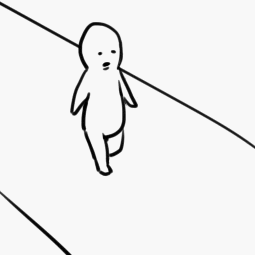
Suppose that a pair of spouses are eating dinner together at a table. They only have __one fork to share__, so __only one of them can eat at any given point__. Additionally, the spouses are polite to each other, so even if one spouse is hungry and wants to eat their food, __they will leave the fork on the table if their partner is also hungry.__ This specification is at the heart of creating a livelock for this problem: __when both spouses are hungry, each will wait for the other to eat first, creating an infinite loop in which each spouse switches between wanting to eat and waiting for the other spouse to eat.__



In [ ]:
import threading
import time


class Spouse(threading.Thread):
    def __init__(self, name, partner):
        threading.Thread.__init__(self)
        self.name = name
        self.partner = partner
        self.hungry = True

    def run(self):
        while self.hungry:
            print("%s is hungry and wants to eat." % self.name)

            if self.partner.hungry:
                print("%s is waiting for their partner to eat first..." % self.name)
            else:
                with fork:
                    print("%s has stared eating." % self.name)
                    time.sleep(5)

                    print("%s is now full." % self.name)
                    self.hungry = False


fork = threading.Lock()

partner1 = Spouse("Wife", None)
partner2 = Spouse("Husband", partner1)
partner1.partner = partner2

partner1.start()
partner2.start()

partner1.join()
partner2.join()

print("Finished.")


# Chapter 13: Starvation
Starvation: if there is a process (or a thread) that is unable to make any progress because it cannot gain access to the necessary process, the process (or thread) is experiencing starvation.

It is quite common for a concurrent program to implement some sort of ordering between the different processes in its execution. For example, consider a program that has three separate processes, as follows:

1. One is responsible for handling extremely pressing instructions that need to be run as soon as the necessary resources become available.
2. Another process is responsible for other important executions, which are not as essential as the tasks in the first process.
3. The last one handles miscellaneous, very infrequent tasks.

Furthermore, these three processes need to utilize the same resources in order to execute their respective instructions.

Intuitively, we have every reason to implement a specification that allows the first process to have the highest priority of execution and access to resources, then the second process, and then the last process, with the lowest priority. However, imagine situations in which the first two processes (with higher priorities) run so often that the third process cannot execute its instructions; anytime the third process needs to run, it checks to see whether the resources are available to be used and finds out that one of the other higher-priority processes is using them.

This is a situation of starvation – the third process is given no opportunity to execute and, therefore, no progress can be made with that process. In a typical concurrent program, it is quite common to have more than three processes at different priority levels, yet the situation is fundamentally similar – some processes are given more opportunities to run and, therefore, they are constantly executing. Others have lower priorities and cannot access the necessary resources to execute.

### Priority inversion
A characteristic of a good scheduling algorithm is the ability to distribute the execution flow and allocate the resources equally and appropriately.

As mentioned previously, many concurrent systems and programs implement a specific order of priority, in terms of process and thread execution. This implementation of ordered scheduling may very likely lead to the starvation of processes and threads of lower priorities and can result in a condition called priority inversion.

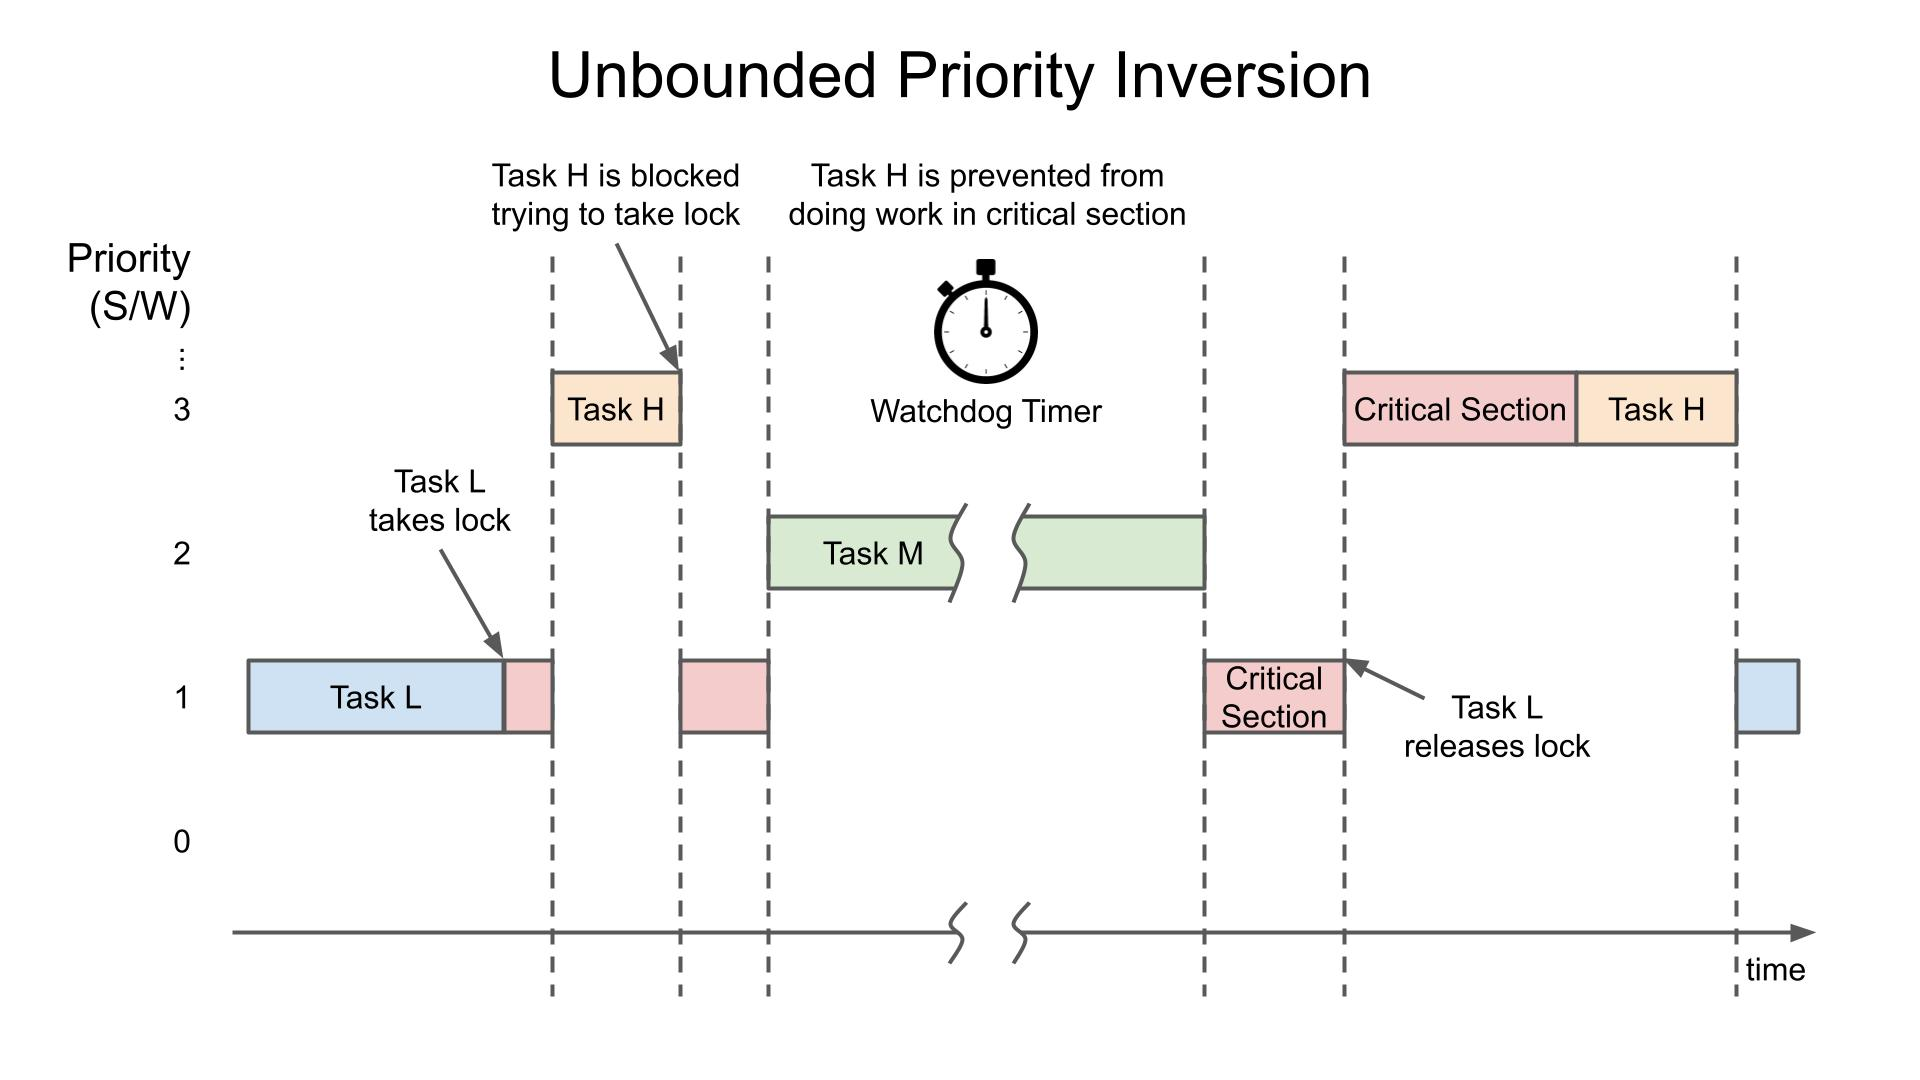
### Causes of starvation
With the complexity of designing a scheduling algorithm in mind, let's discuss the specific causes of starvation. The situations that we described in the preceding section indicate some potential causes of a starvation situation. However, starvation can arise from a number of sources, as follows:

- Processes (or threads) with high priorities dominate the execution flow in the CPU and, hence, low-priority processes (or threads) are not given the opportunity to execute their own instructions.
- Processes (or threads) with high priorities dominate the usage of non-shareable resources and, hence, low-priority processes (or threads) are not given the opportunity to execute their own instructions. This situation is similar to the first one but addresses the priority of accessing resources, instead of the priority of the execution itself.
- Processes (or threads) with low priorities are waiting for resources to execute their instructions, but as soon as the resources become available, other processes (or threads) with higher priorities are immediately given access to them, so the low-priority processes (or threads) wait indefinitely.



Reader-writter problem: we have a shared resource, which, in most cases, is a text file. Different threads interact with that text file; each is either a reader or a writer. A reader is a thread that simply accesses the shared resource (the text file) and reads in the data included in that file, while a writer is a thread that accesses, and possibly mutates, the contents of the text file

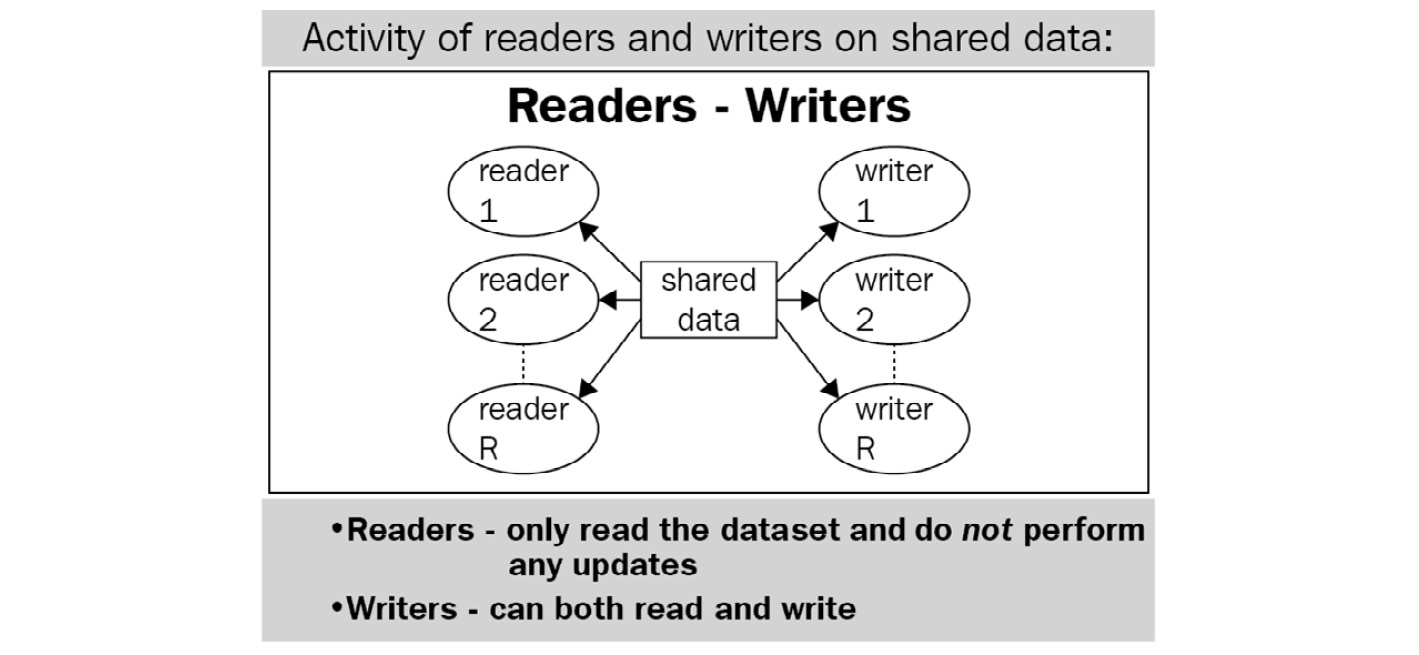

### Appraoch 1: 
As we mentioned, the problem asks us to come up with a scheduling algorithm so that readers and writers can access the text file appropriately and efficiently, without mishandling or corrupting the data that is included. A naive solution to this problem is to impose a lock on the text file so that it becomes a non-shareable resource; this means that only one thread (either a reader or a writer) can access (and potentially manipulate) the text file at any given time.

Yet, this approach simply equates to a sequential program – if the shared resource can be utilized by only one thread at a given time, none of the processing time between different threads can be overlapped and, effectively, the execution becomes sequential. Therefore, this is not an optimal solution, as it is taking advantage of concurrent programming.

In the preceding script, the __writer()__ function, which is to be called by a threading.Thread instance (in other words, a separate thread), specifies the logic of the writer threads that we discussed previously – accessing the shared resource (in this case, the global variable, text, which is simply a Python string) and writing some data to the resource. Note that we are putting all of its instructions inside a while loop to simulate the constant nature of the application (writers and readers constantly trying to access the shared resource).

We can also see the reader logic in the __reader()__ function. Before asking for access to the shared resource, each reader will increment a counter for the number of readers that are currently active and trying to access the resource. Similarly, after reading data off the file, each reader needs to decrement the number of readers. During this process, if a reader is the first reader to access the file (in other words, when the counter is one), it will put a lock on the file so that no writers can access it; conversely, when a reader is the last reader to read the file, it has to release that lock.

One note about the handling of that counter of readers – you might have noticed that we are using a lock object named __rcounter__ when incrementing/decrementing the counter variable __(rcount)__. This is a method that is used to avoid a __race condition__, which is another common concurrency-related problem, for the counter variable

In [ ]:
import threading

def writer():
    global text

    while True:
        with resource:
            print(f"Writing being done by {threading.current_thread().name}.")
            text += f"Writing was done by {threading.current_thread().name}. "


def reader():
    global rcount

    while True:
        with rcounter:
            rcount += 1
            if rcount == 1:
                resource.acquire()

        print(f"Reading being done by {threading.current_thread().name}:")
        print(text)

        with rcounter:
            rcount -= 1
            if rcount == 0:
                resource.release()


text = "This is some text. "
rcount = 0

rcounter = threading.Lock()
resource = threading.Lock()

threads = [threading.Thread(target=reader) for i in range(3)] + [
    threading.Thread(target=writer) for i in range(2)
]

for thread in threads:
    thread.start()

As you can see, there is a specific pattern in the preceding output – all of the threads that were accessing the shared resource were readers. In fact, throughout my entire output, no writer was able to access the file and, therefore, the text variable only contains the initial string, This is some text., and was not altered in any way. The output that you obtain should also have the same pattern (the shared resource not being altered).

In this case, the writers are experiencing starvation, as none of them are able to access and use the resource. This is a direct result of our scheduling algorithm; since multiple readers are allowed to access the text file simultaneously, if there are multiple readers accessing the text file frequently enough, it will create a continuous stream of readers going through the text file, leaving no room for a writer to attempt to access the file.

This scheduling algorithm inadvertently gives priority to the readers over the writers and is therefore called reader preference. So, this design is undesirable.

### Approach 2:
The problem with the first approach is that when a reader is accessing the text file and a writer is waiting for the file to be unlocked, if another reader starts its execution and wants to access the file, it will be given priority over the writer that has already been waiting. Additionally, if more and more readers keep requesting access to the file, the writer will be waiting __indefinitely__, and that was what we observed in our first code example.

To address this problem, we will implement the specification that once a writer makes a request to access the file, no reader should be able to jump in line and access the file before that writer. To do this, we will have an additional lock object in our program to specify whether a writer is waiting for the file and, consequently, whether a reader thread can attempt to read the file; we will call this lock __read_try__.

Similar to how the first of the readers accessing the text file always locks it from the writers, we will now have the first of the multiple writers that are waiting to access the __read_try__ file lock, so that no reader can, again, jump in line before those writers that requested access before it. As we discussed in reference to the readers, since we are keeping track of the number of writers waiting for the text file, we will need to implement a counter for the number of writers, and its corresponding lock, in our program.

In [ ]:
import threading

def writer():
    global text
    global wcount

    while True:
        with wcounter:
            wcount += 1
            if wcount == 1:
                read_try.acquire()

        with resource:
            print(f"Writing being done by {threading.current_thread().name}.")
            text += f"Writing was done by {threading.current_thread().name}. "

        with wcounter:
            wcount -= 1
            if wcount == 0:
                read_try.release()

def reader():
    global rcount

    while True:
        with read_try:
            with rcounter:
                rcount += 1
                if rcount == 1:
                    resource.acquire()

            print(f"Reading being done by {threading.current_thread().name}:")
            print(text)

            with rcounter:
                rcount -= 1
                if rcount == 0:
                    resource.release()


text = "This is some text. "
wcount = 0
rcount = 0

wcounter = threading.Lock()
rcounter = threading.Lock()
resource = threading.Lock()
read_try = threading.Lock()

threads = [threading.Thread(target=reader) for i in range(3)] + [
    threading.Thread(target=writer) for i in range(2)
]

for thread in threads:
    thread.start()


It can be observed that while some readers were able to access the text file (indicated by the first four lines of my output), once a writer gained access to the shared resource, no reader was able to access it anymore. The rest of my output included messages about writing instructions – Writing being done by, and so on. As opposed to what we saw in the first solution of the readers-writers problem, this solution is giving priority to writers, and, as a consequence, the readers are starved. This is therefore called __writer preference__.



### Approach 3: 

In this solution, we will implement __a lock that also utilizes this logic but is then applied to both readers and writers__. All of the threads will then be subjected to the constraints of the lock, and equal priority will hence be achieved among the separate threads.

Specifically, this is a lock that specifies whether a thread will be given access to the text file at a given moment; we will call this the __service lock__. Each writer or reader has to try to acquire this service lock before executing any of its instructions. A writer, having obtained this service lock, will also attempt to obtain the resource lock and release the service lock immediately thereafter. The writer will then execute its writing logic and finally release the resource lock at the end of its execution.

On the other hand, a reader will also need to acquire the service lock first. Since we are still allowing multiple readers to access the resource at the same time, we are implementing the reader counter and its corresponding lock.


In [ ]:
import threading


def writer():
    global text

    while True:
        with service:
            resource.acquire()

        print(f"Writing being done by {threading.current_thread().name}.")
        text += f"Writing was done by {threading.current_thread().name}. "

        resource.release()


def reader():
    global rcount

    while True:
        with service:
            rcounter.acquire()
            rcount += 1
            if rcount == 1:
                resource.acquire()
        rcounter.release()

        print(f"Reading being done by {threading.current_thread().name}:")
        # print(text)

        with rcounter:
            rcount -= 1
            if rcount == 0:
                resource.release()


text = "This is some text. "
rcount = 0

rcounter = threading.Lock()
resource = threading.Lock()
service = threading.Lock()

threads = [threading.Thread(target=reader) for i in range(3)] + [
    threading.Thread(target=writer) for i in range(2)
]

for thread in threads:
    thread.start()


The pattern that we have with this current output is that the readers and writers are able to access the shared resource cooperatively and efficiently; all of the readers and writers are executing their instructions, and no thread is being starved by this scheduling algorithm.

Note that as you work with a readers-writers problem in your concurrent program, you do not have to reinvent the wheel regarding the approaches that we just discussed. PyPI actually has an external library called __readerwriterlock__ that contains the implementation of the three approaches in Python, as well as support for timeouts. Go to https://pypi.org/project/readerwriterlock/ to find out more about the library and its documentation.

### Solutions to starvation

- Increasing the priority of low-priority threads: As we did with the writer threads in the second approach and the reader threads in the third approach to the readers-writers problem, prioritizing the threads that would otherwise not have any opportunity to access the shared resource can successfully eliminate starvation.
- First-in-first-out thread queue: To ensure that a thread that started waiting for the shared resource before another thread will be able to acquire the resource before the other thread, we can keep track of the threads requesting access in a first-in-first-out queue.
- Other methods: Several methods can also be implemented to balance the selection frequency of different threads – for example, a priority queue that also gives gradually increasing priority to threads that have been waiting in the queue for a long time, or if a thread has been able to access the shared resource many times, it will be given less priority.

# Chapter 14: Race Conditions
Definition: a race condition is defined as a phenomenon during which the output of a system is both indeterminate and dependent on the scheduling algorithm and the order in which tasks are scheduled and executed. When data becomes mishandled or corrupted during this process, a race condition becomes a bug in the system. Given the nature of this problem, it is quite common for a race condition to occur in concurrent systems, which emphasizes the importance of scheduling and coordinating independent tasks.

A race condition can occur in both an electronic hardware system and a software application; in this chapter, we will only discuss race conditions in the context of software development – specifically, concurrent software applications. This section will cover the theoretical foundations of race conditions and their root causes along with the concept of critical sections.

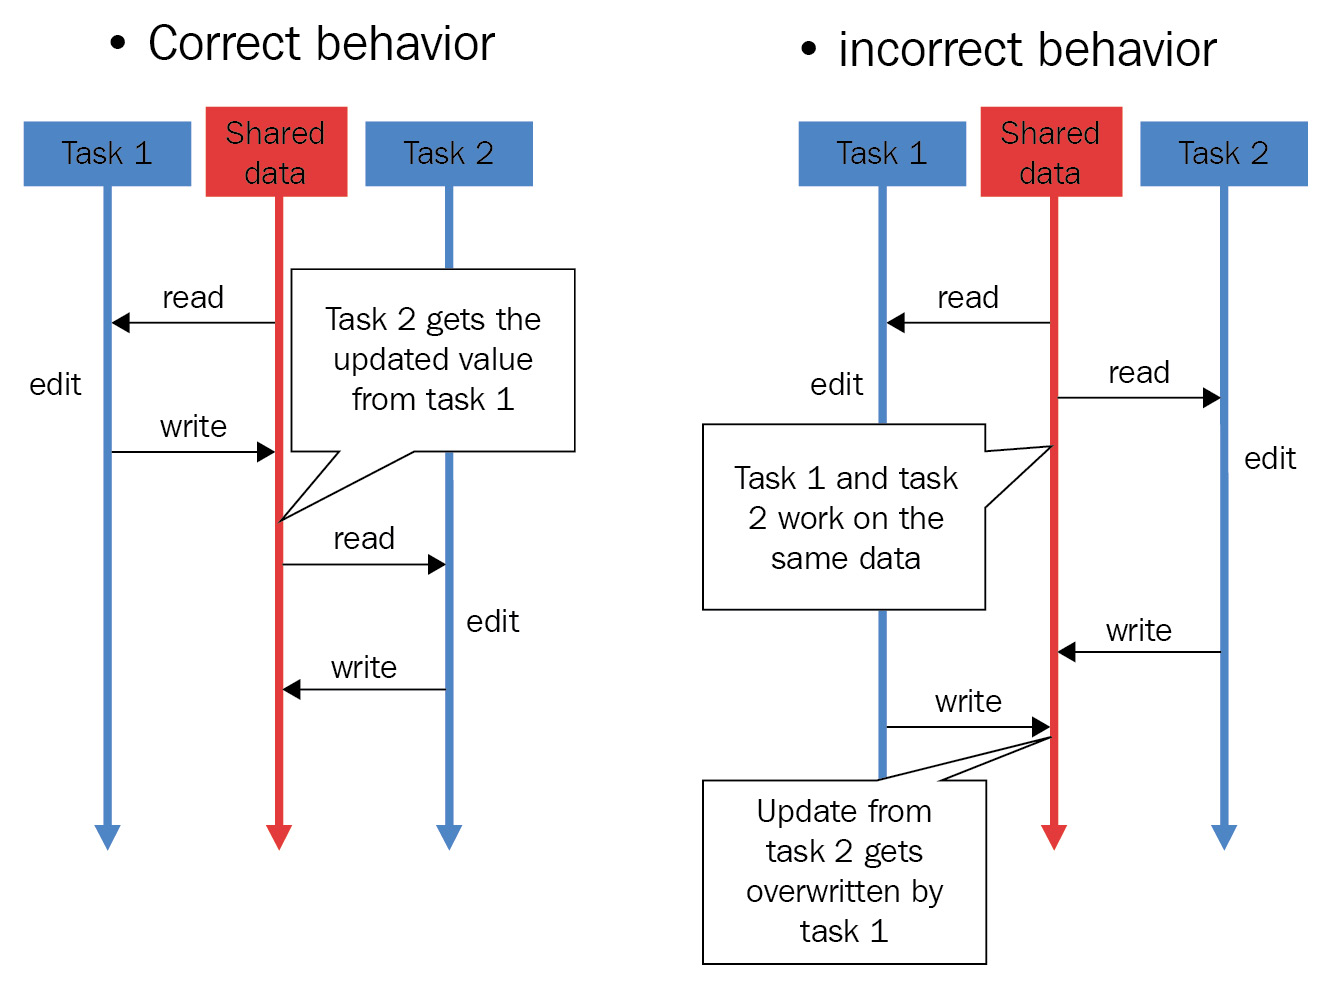

### Race condition in transfer money
If two attempts of transfering money are kicked off simultaneously, in different processes or threads, we may observe some undesired behavior:


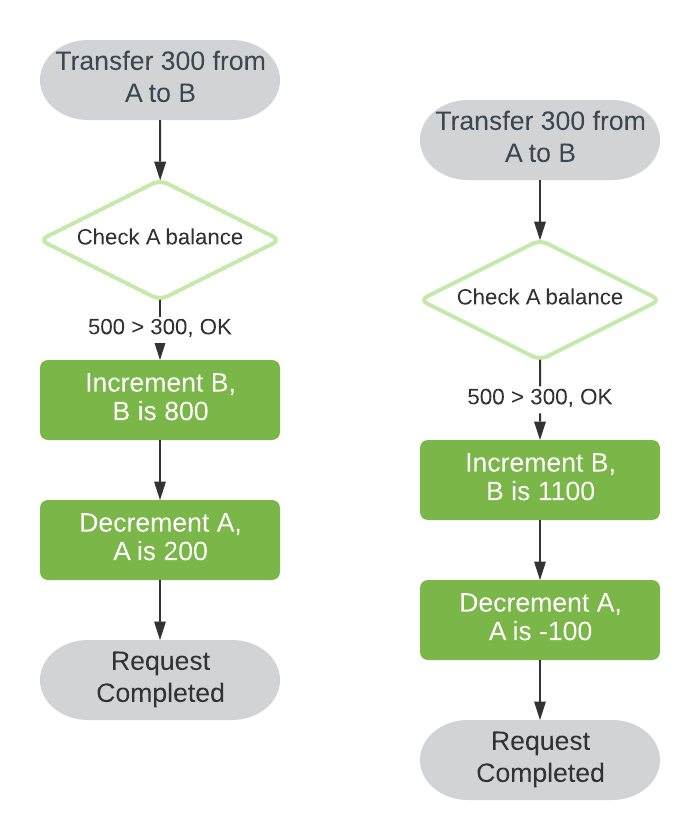

## Simulating race conditions in Python
The goal of the preceding update() function is to increment __a global variable called counter__, and it is to be called by a separate thread in our script. Inside the function, we are interacting with __a shared resource—in this case, counter__. Then, we assign the value of counter to another __local variable, called current_counter__ (this is to simulate the process of reading data from more complex data structures for the shared resources).

Next, we will pause the execution of the function by using the time.sleep() method. The length of the period during which the program will be __paused is pseudo-randomly chosen between 0 and 1__, generated by the function call, __random.randint(0, 1)__. So, the program will either pause for one second or not at all. Finally, we assign the newly computed value of current_counter (which is its one-increment) to the originally shared resource (the counter variable).

Here, we are initializing the counter global variable with a set of threading.Thread objects in order to execute the update() function concurrently; we are initializing __20 thread objects__ to __increment our shared counter 20 times__. After starting and joining all of the threads that we have, we can finally print out the end value of our shared counter variable.

In [ ]:
import threading
import random
import time


def update():
    global counter

    current_counter = counter  # reading in shared resource
    time.sleep(random.randint(0, 1))  # simulating heavy calculations
    counter = current_counter + 1  # updating shared resource


counter = 0

threads = [threading.Thread(target=update) for i in range(20)]

for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

print(f"Final counter: {counter}.")
print("Finished.")

Final count is not __20__. The result is random.

The final value of the counter is dependent on the number of threads that spend one second pausing and the number of threads not pausing at all. Since these two numbers are, in turn, dependent on the random.randint() method, the final value of the counter changes between different runs of the program. 

## Locks as a solution to race conditions
Intuitively, since the race conditions that we observed arose when multiple threads or processes accessed and wrote to a shared resource simultaneously, the key idea behind solving race conditions is isolating the executions of different threads/processes, especially when interacting with a shared resource. Specifically, we need to make sure that a thread/process can only access the shared resource after any other threads/processes interacting with the resource have finished their interactions with that resource.

In the following diagram, __Thread B__ is blocked from accessing the shared resource—the critical section named __var__—by a __mutex (mutual exclusion) lock__. This is because __Thread A__ is already accessing the resource:


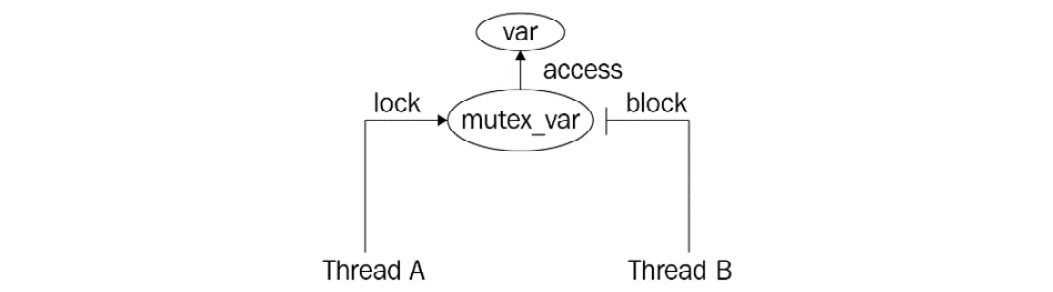
## Adding a lock in Python
The execution instructions of a thread specified in the __update()__ function are under the context manager of a lock object named __count_lock__. So, every time a thread is called to run the function, it will first have to acquire the lock object before any instructions can be executed. I

In [ ]:
import threading
import random
import time


def update():
    global counter

    with count_lock:
        current_counter = counter  # reading in shared resource
        time.sleep(random.randint(0, 1))  # simulating heavy calculations
        counter = current_counter + 1


counter = 0
count_lock = threading.Lock()

threads = [threading.Thread(target=update) for i in range(20)]

for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

print(f"Final counter: {counter}.")
print("Finished.")

Here, you can see that the counter was successfully incremented 20 times and held the correct value at the end of the program. Furthermore, no matter how many times the script is executed, the final value of the counter will __always be 20__.

## The downside of locks
In Chapter 12, Deadlocks, we covered an interesting phenomenon in which the use of locks can lead to undesirable results. Specifically, we discovered that with enough locks implemented in a concurrent program, the whole program can become __sequential__. 

Let's analyze this concept with our current program. 

In [ ]:
import threading
import random

random.seed(0)
import time


def update(pause_period):
    global counter

    with count_lock:
        current_counter = counter  # reading in shared resource
        time.sleep(pause_period)  # simulating heavy calculations
        counter = current_counter + 1  # updating shared resource


pause_periods = [random.randint(0, 1) for i in range(20)]

###########################################################################

counter = 0
count_lock = threading.Lock()

start = time.perf_counter()
for i in range(20):
    update(pause_periods[i])

print("--Sequential version--")
print(f"Final counter: {counter}.")
print(f"Took {time.perf_counter() - start : .2f} seconds.")

###########################################################################

counter = 0

threads = [threading.Thread(target=update, args=(pause_periods[i],)) for i in range(20)]

start = time.perf_counter()
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

print("--Concurrent version--")
print(f"Final counter: {counter}.")
print(f"Took {time.perf_counter() - start : .2f} seconds.")

###########################################################################

print("Finished.")


The concurrent program is taking just as much time as its __sequential version__, which negates one of the biggest purposes of implementing concurrency in a program: __improving speed__.

Recall that, in our program, the critical section is being protected by a lock object, and no multiple threads can access it at the same time. Since the execution of the program (incrementing the counter 20 times) depends on a thread accessing the critical section, the placement of the lock object in the critical section means that only one thread can be executing at any given time. With this specification, the executions of any two threads cannot overlap with each other, and no additional speed can be gained from this implementation of concurrency.

This is the phenomenon that we encountered when analyzing the problem of deadlock: __if enough locks are placed in a concurrent program, that program will become entirely sequential.__

## Locks do not lock anything

Locks __need to be concretely linked__ to the resources that they are supposed to protect, and nothing should be able to access a resource without first acquiring the lock that is associated with it.

So, if the thread/process execution logic does not require any interaction with the lock object associated with the shared resource, that thread or process can simply gain access to the resource without difficulty, potentially resulting in the mismanipulation and corruption of data.

If any of these components __fail to interact with that lock, it can simply bypass the protection implemented by the lock__ and access the shared resource. More importantly, this characteristic of locks also has implications regarding the security of a concurrent program. If an outside, __malicious agent is connected to the system (for instance, a malicious client interacting with a server) and intends to corrupt the data shared across the system__, that agent can be instructed to simply ignore the lock object and access that data in an intrusive way.

Alternatively, other concurrent synchronization tools, such as __atomic message queues__ can provide a solution to this problem.

## Race conditions in real life
### Security

Concurrent programming can have significant implications in terms of the security of the system in question. Recall that a race condition arises between the process of reading and altering the data of a resource; a race condition in an authenticating system can cause the corruption of data between the __time of check__ (when the credentials of an agent are checked) and the __time of use__ (when the agent can utilize the resource). This problem is also known as a __Time-Of-Check-To-Time-Of-Use (TOCTTOU)__ bug, which is undoubtedly detrimental to security systems.

Interestingly, race conditions can also be used to __implement computer security__. As race conditions result from the uncoordinated access of multiple threads/processes to a shared resource, the specification in which a race condition occurs is significantly random.

So, race conditions are sometimes __intentionally provoked__, and the information obtained when the race condition occurs can be used to generate digital fingerprints for security processes—again, this information is significantly random and is, therefore, valuable for security purposes.

# Chapter 15: The Global Interpreter Lock (GIL)

The definition of GIL : __a lock that will only allow one thread__ to access and control the Python interpreter at any given time, the GIL in Python is often known as the infamous GIL that prevents multithreaded programs from reaching their fully optimized speed.

Overall, in Python programs, variables simply make references to the actual values (objects), and an assignment statement between two variables makes the two variables reference the same object, as opposed to copying the actual value to another memory location, as in C++.

Let's analyze this feature in Python.

In [5]:
import sys

print(f"Reference count when direct-referencing: {sys.getrefcount([7])}.")

a = [7]
print(f"Reference count when referenced once: {sys.getrefcount(a)}.")

b = a
print(f"Reference count when referenced twice: {sys.getrefcount(a)}.")

###########################################################################

a[0] = 8
print(f"Variable a after a is changed: {a}.")
print(f"Variable b after a is changed: {b}.")

print("Finished.")

Reference count when direct-referencing: 1.
Reference count when referenced once: 2.
Reference count when referenced twice: 3.
Variable a after a is changed: [8].
Variable b after a is changed: [8].
Finished.


In this example, we are looking at the management of the value __[7]__ (a list of one element: the integer __7__). We mentioned that values in Python are stored independently of variables, and value management in Python simply references variables to the appropriate values. The __sys.getrefcount()__ method in Python takes in an object and __returns the counter of all references that the value associated with that object has__. Here, we are calling __sys.getrefcount()__ three times: on the actual value, __[7]__; the variable a that is assigned the value; and finally, the variable b that is assigned with the variable a.

As you can see, this output is consistent with what we discussed as the following ways:

1. For the first sys.getrefcount() function call, there is __only one reference count for the value [7]__, which is created when we directly reference it.
2. When we assign the list to variable a, the value has two references, since a is now associated with the value.
3. Finally, when a is assigned to b, [7] is additionally referenced by b, and the reference count is now 3.
4. In the output of the second part of the program, we can see that when we changed the value of the variable that a references, [7] was mutated instead of variable a. As a result, variable b, which was referencing the same value as a, also had its value changed.
The following diagram illustrates this process:

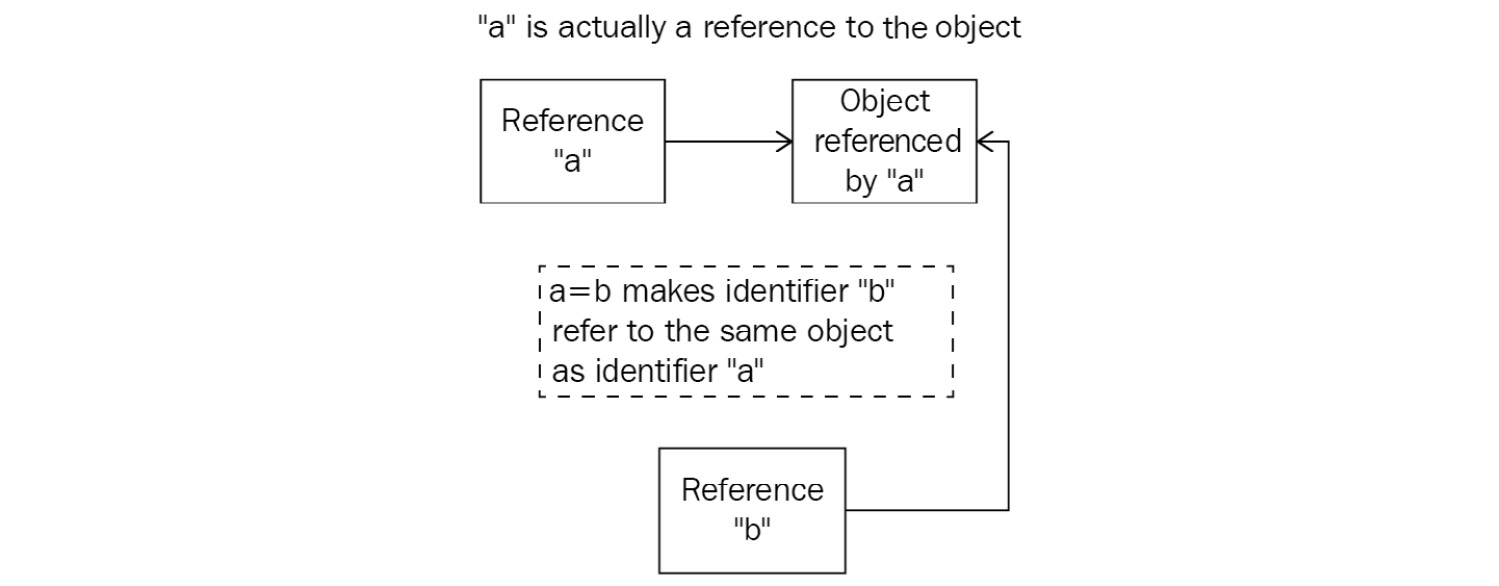

## The problem that the GIL addresses
We can see references to a given value in Python are constantly changing in a program, and keeping track of the reference count for a value is therefore highly important.

In a Python concurrent program, this reference count is a shared resource that needs protection from race conditions. In other words, __this reference count is a critical section that__, if handled carelessly, will result in an incorrect interpretation of how many variables are referencing a particular value. This will cause memory leaks that will make Python programs significantly inefficient and may even release a memory that is actually being referenced by some variables, losing that value forever.

__A solution to making sure that race conditions will not occur with regard to a particular shared resource is to place a lock on that resource__, effectively allowing one thread, at the most, to access the resource at any given time within a concurrent program. We also discussed that if enough locks are placed in a concurrent program, that program will become entirely sequential, and no additional speed will be gained by implementing concurrency.

The GIL is a solution to the combination of the two preceding problems, being one single lock on the entire execution of Python. The GIL must first be acquired by any Python instruction that wants to be executed (central processing unit (CPU)-bound tasks), __preventing a race condition from occurring for any reference count__.

Since the __GIL is a lightweight, overarching lock for the entire execution of Python__, no other lock needs to be implemented to guarantee the integrity of other critical sections, keeping the performance overhead of Python programs at a minimum.

## Problems raised by the GIL

Intuitively, with a lock guarding all CPU-bound tasks in Python, a concurrent program will not be able to become fully __multithreading__.

In [ ]:
import time
import threading

COUNT = 50000000

def countdown(n):
    while n > 0:
        n -= 1

###########################################################################

start = time.time()
countdown(COUNT)

print("Sequential program finished.")
print(f"Took {time.time() - start : .2f} seconds.")

###########################################################################

thread1 = threading.Thread(target=countdown, args=(COUNT // 2,))
thread2 = threading.Thread(target=countdown, args=(COUNT // 2,))

start = time.time()
thread1.start()
thread2.start()
thread1.join()
thread2.join()

print("Concurrent program finished.")
print(f"Took {time.time() - start : .2f} seconds.")

We then call countdown() on __50,000,000__ once, as a sequential program. Finally, we call the function twice, each in a separate thread, on __25,000,000__, which is exactly __half__ of __50,000,000__

Theoretically, the multithreading version of the program should take half as long as the sequential version, as the task is effectively being split in half and run in parallel, via the two threads that we created. However, the output produced by the program would suggest otherwise.

Contrary to what we predicted, the __concurrent__ version of the countdown took almost as long as the __sequential__ version; multithreading did not offer any considerable speedup for our program. This is a direct effect of having the GIL guarding CPU-bound tasks, as multiple threads are not allowed to run simultaneously. Sometimes, a multithreading program can take even longer to complete its execution than its sequential counterpart, since there is also the overhead of acquiring and releasing the GIL.

The creator of Python, Guido van Rossum, also commented on this topic in his article It isn't Easy to Remove the GIL, as follows:

__"I'd welcome a set of patches into Py3k only if the performance for a single-threaded program (and for a multi-threaded but I/O-bound program) does not decrease."__

Unfortunately, this request has not been achieved by any of the proposed alternatives to the GIL. The GIL remains an integral part of the Python language.

## Working with the GIL
There are a few ways to deal with the GIL in your Python applications, and these will be addressed in the following sections.

### Implementing multiprocessing, rather than multithreading
This is perhaps the most popular and easiest method to circumvent the GIL and achieve optimal speed in a concurrent program. As the GIL only prevents multiple threads from executing CPU-bound tasks simultaneously, processes executing over multiple cores of a system, each having its own memory space, are completely immune to the GIL.

Count down example of __50,000,000__ by multi-processing.

Let's compare the performance of that CPU-bound program when it is __sequential, multithreading, and multiprocessing__.

In [ ]:
import time
import threading
from multiprocessing import Pool

COUNT = 50000000

def countdown(n):
    while n > 0:
        n -= 1

if __name__ == "__main__":

    #######################################################################
    # Sequential

    start = time.time()
    countdown(COUNT)

    print("Sequential program finished.")
    print(f"Took {time.time() - start : .2f} seconds.")
    print()

    #######################################################################
    # Multithreading

    thread1 = threading.Thread(target=countdown, args=(COUNT // 2,))
    thread2 = threading.Thread(target=countdown, args=(COUNT // 2,))

    start = time.time()
    thread1.start()
    thread2.start()
    thread1.join()
    thread2.join()

    print("Multithreading program finished.")
    print(f"Took {time.time() - start : .2f} seconds.")
    print()

    #######################################################################
    # Multiprocessing

    pool = Pool(processes=2)
    start = time.time()
    pool.apply_async(countdown, args=(COUNT // 2,))
    pool.apply_async(countdown, args=(COUNT // 2,))
    pool.close()
    pool.join()

    print("Multiprocessing program finished.")
    print(f"Took {time.time() - start : .2f} seconds.")

Since __processes are fairly heavyweight__, multiprocessing instructions contain significant overhead, which is the reason why the speed of the multiprocessing program was __not exactly half of the sequential program__.

### Getting around the GIL with native extensions
There are __Python-native extensions that are written in C/C++ and are therefore able to avoid the limitations that the GIL sets out__; one example is the most popular Python scientific computing package, __NumPy__. Within these extensions, __manual releases of the GIL__ can be made so that the execution can simply __bypass the lock__. However, these releases need to be __implemented carefully and accompanied by the reassertion of the GIL__ before the execution goes back to the main Python execution.

### Utilizing a different Python interpreter
The GIL only exists in __CPython__, which is the most common interpreter for the language by far and is __built in C__. However, there are other interpreters for Python, such as __Jython (written in Java)__ and __IronPython (written in C++)__, that can be used to avoid the GIL and its effects on multithreading programs.